In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as mtcs

%matplotlib inline

# Data uploading&preview

In [2]:
data = pd.read_csv('./data/train.csv')

data

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0
3,43.976744,7.648293,3.837209,14.392765,168.885456,175.277251,1.622298,7.629033,12.180817,9.070719,...,5.879135,4.280132,4.563045,5.007714,5.159773,5.393628,5.640132,5.472271,5.741399,0.0
4,24.320988,6.534011,3.567901,8.913580,163.076959,96.019681,1.380679,6.566695,4.417010,8.058783,...,8.148663,4.624973,5.173321,5.720312,6.259342,6.626469,7.062406,7.472998,7.829842,0.0
5,20.924051,6.134299,3.037975,6.506329,165.707039,82.761541,1.381957,6.187547,4.684599,7.660347,...,6.087556,4.430817,4.820282,5.183187,5.595176,5.489454,5.604998,5.847522,5.987080,0.0
6,34.150000,6.740695,3.733333,10.214815,164.252922,135.639059,1.620887,6.781702,8.631090,8.248393,...,6.198225,4.471639,4.801970,5.237107,5.493833,5.573816,5.764799,5.865760,5.998937,0.0
7,23.833333,6.395508,3.141026,8.717949,163.221967,94.106131,1.435936,6.443753,5.834402,7.904135,...,6.582328,4.600158,5.032071,5.499726,5.978728,5.995208,6.179952,6.364051,6.481290,0.0
8,32.380952,6.152543,2.857143,6.402116,164.380868,128.391104,1.687697,6.232890,4.476844,7.736528,...,0.000000,3.449988,3.865979,4.506730,4.765906,4.965028,3.840795,3.595598,0.000000,0.0
9,45.228571,6.608449,3.714286,9.180952,159.167580,180.141749,1.981354,6.690537,8.428546,8.221041,...,5.214936,3.828641,4.234107,4.682131,4.890349,5.192957,5.342334,5.402677,5.303305,0.0


[ 0.  1.]


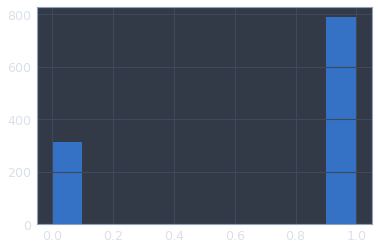

In [3]:
print(data.y.unique())
plt.hist(data.y);

In [108]:
print(data.isnull().sum().sum())

num_1 = data[data.y == 1].shape[0] 
num_0 = data[data.y == 0].shape[0]

print(num_1, num_0, num_1 / (num_0 + num_1))

0
790 315 0.7149321266968326


# Common functions

In [45]:
def weight_init(name, shape):
    return tf.get_variable(name, initializer=tf.random_normal(shape=shape,
                                                              stddev=0.1))
def bias_init(name, shape):
    return tf.get_variable(name, initializer=tf.constant(0.1, shape=shape))

def elastic_net(x, l1, l2):
    return l1 * ( (1-l2) / 2 * tf.norm(x, 2) ** 2 + 
                   l2 * tf.norm(x, 1))

def batch_data(*matrxs, batch_size):
    for batch_i in range(matrxs[0].shape[0] // batch_size):
        yield tuple(x.iloc[batch_i * batch_size : (batch_i + 1) * batch_size] 
                     for x in matrxs)
        
def split_data(data, train_size=0.5, test_size=0.25, validate_size=0.25):
    train_data, test_val_data = ms.train_test_split(data, train_size=train_size)
    test_data, val_data = ms.train_test_split(test_val_data,
                                              train_size=test_size / (test_size+validate_size))
    
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    validate_X, validate_y = val_data.drop('y', axis=1), val_data[['y']]
    
    return (train_X, train_y, test_X, test_y, validate_X, validate_y)

# Feature selection

## DFS

In [128]:
class DFS:
    def __init__(self, layers_sizes, batch_size=32, lambda1=1e-3, lambda2=1.,
                 alpha1=1e-3, alpha2=0.):
        self.layers_sizes = layers_sizes
        self.num_layers = len(layers_sizes)
        self.batch_size = batch_size
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        
        
    def fit(self, X, y, num_epochs=10, test_data=None):
        self._build_graph_(X.shape[1])
        self.sess = tf.InteractiveSession()
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(num_epochs):
            X = X.sample(frac=1, random_state=epoch_i)
            y = y.sample(frac=1, random_state=epoch_i)
            epoch_loss = 0
            for batch_X, batch_y in batch_data(X, y, 
                                               batch_size=self.batch_size):
                train_loss, _ = self.sess.run([self.total_loss, self.train_step],
                                               feed_dict = {self.x: batch_X,
                                                            self.y: batch_y})
                epoch_loss += train_loss
            epoch_loss /= X.shape[0] // self.batch_size
            
            train_predict = self.predict(X)
            train_accuracy = mtcs.accuracy_score(y, train_predict)
            if test_data is not None:
                test_X, test_y = test_data
                test_predict = self.predict(test_X)
                test_accuracy = mtcs.accuracy_score(test_y, test_predict)
                print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}."
                      f"Train accuracy: {train_accuracy}. Test accuracy: {test_accuracy}.")
            else:
                print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}. "
                      f"Train accuracy: {train_accuracy}.")
            
    def predict_proba(self, X):
        predictions_proba = self.sess.run(self.predictions, feed_dict={self.x: X})
        
        return predictions_proba
    def predict(self, X):
        predictions_proba = self.predict_proba(X)
        
        return list(map(np.argmax, predictions_proba))
        
    def _build_graph_(self, num_features):
        tf.reset_default_graph()
        
        ###Placeholders 
        x = tf.placeholder(tf.float32, [None, num_features], 'x_ph')
        y = tf.placeholder(tf.int32, [None], 'y_ph')
        
        ###Weights initialization
        w = tf.get_variable("dfs_features_weight", 
                            initializer = tf.constant(1., shape=[num_features]))
        self.layers_sizes = [num_features] + self.layers_sizes
        W, b = [], []
        for layer_i in range(self.num_layers):
            W.append(weight_init(f"layer_{layer_i}_weights",
                                 shape=[self.layers_sizes[layer_i],
                                        self.layers_sizes[layer_i+1]]))
            b.append(bias_init(f"layer_{layer_i}_bias",
                               shape=[self.layers_sizes[layer_i+1]]))
        
        ###Input transformations
        logits = x * w #feature selection
        for layer_i in range(self.num_layers):
            logits = tf.matmul(logits, W[layer_i]) + b[layer_i]
        predictions = tf.nn.softmax(logits)
            
        ###Loss calculation
        logloss = tf.reduce_sum(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                                       logits=logits))
        w_loss = elastic_net(w, self.lambda1, self.lambda2)
        W_loss = tf.reduce_sum([elastic_net(W_i, self.alpha1, self.alpha2) for W_i in W])
        
        total_loss = tf.reduce_sum(logloss + w_loss + W_loss)
        
        ###Optimizer
        train_step = tf.train.AdamOptimizer().minimize(total_loss)
        
        self.x = x
        self.y = y
        self.predictions = predictions
        self.total_loss = total_loss
        self.train_step = train_step
        

In [129]:
(train_X, train_y,
 test_X, test_y,
 validate_X, validate_y) = split_data(data)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [134]:
dfs = DFS([93, 93, 128, 64, 2])

dfs.fit(train_X, train_y['y'], num_epochs=1000, test_data=(test_X, test_y))

==> Epoch: 0. Train loss: 186613.03573069852.Train accuracy: 0.4492753623188406. Test accuracy: 0.4746376811594203.
==> Epoch: 1. Train loss: 43859.053825827206.Train accuracy: 0.5072463768115942. Test accuracy: 0.5181159420289855.
==> Epoch: 2. Train loss: 10376.925407858456.Train accuracy: 0.7246376811594203. Test accuracy: 0.677536231884058.
==> Epoch: 3. Train loss: 3748.7440652286305.Train accuracy: 0.4927536231884058. Test accuracy: 0.5652173913043478.
==> Epoch: 4. Train loss: 1931.6045900232652.Train accuracy: 0.7373188405797102. Test accuracy: 0.7028985507246377.
==> Epoch: 5. Train loss: 1777.2765718347887.Train accuracy: 0.33152173913043476. Test accuracy: 0.38768115942028986.
==> Epoch: 6. Train loss: 2033.6887996897979.Train accuracy: 0.6594202898550725. Test accuracy: 0.644927536231884.
==> Epoch: 7. Train loss: 2622.528761919807.Train accuracy: 0.5942028985507246. Test accuracy: 0.5797101449275363.
==> Epoch: 8. Train loss: 2069.4091258329504.Train accuracy: 0.7554347826

==> Epoch: 72. Train loss: 406.1908362893497.Train accuracy: 0.8152173913043478. Test accuracy: 0.7898550724637681.
==> Epoch: 73. Train loss: 468.2148114372702.Train accuracy: 0.8115942028985508. Test accuracy: 0.75.
==> Epoch: 74. Train loss: 340.1519506117877.Train accuracy: 0.7427536231884058. Test accuracy: 0.6992753623188406.
==> Epoch: 75. Train loss: 266.4726804845473.Train accuracy: 0.7862318840579711. Test accuracy: 0.7898550724637681.
==> Epoch: 76. Train loss: 260.4961038477281.Train accuracy: 0.7989130434782609. Test accuracy: 0.7572463768115942.
==> Epoch: 77. Train loss: 267.8394963881549.Train accuracy: 0.8369565217391305. Test accuracy: 0.7391304347826086.
==> Epoch: 78. Train loss: 361.33204852833467.Train accuracy: 0.802536231884058. Test accuracy: 0.7753623188405797.
==> Epoch: 79. Train loss: 305.35291963465073.Train accuracy: 0.7663043478260869. Test accuracy: 0.7318840579710145.
==> Epoch: 80. Train loss: 301.7458068623262.Train accuracy: 0.8387681159420289. Test

==> Epoch: 144. Train loss: 214.66825799381033.Train accuracy: 0.769927536231884. Test accuracy: 0.7463768115942029.
==> Epoch: 145. Train loss: 192.04506470175352.Train accuracy: 0.7626811594202898. Test accuracy: 0.7355072463768116.
==> Epoch: 146. Train loss: 313.9736680423512.Train accuracy: 0.7862318840579711. Test accuracy: 0.75.
==> Epoch: 147. Train loss: 353.59757546817553.Train accuracy: 0.8170289855072463. Test accuracy: 0.7862318840579711.
==> Epoch: 148. Train loss: 247.82017135620117.Train accuracy: 0.7844202898550725. Test accuracy: 0.7463768115942029.
==> Epoch: 149. Train loss: 179.65592821906594.Train accuracy: 0.7028985507246377. Test accuracy: 0.6956521739130435.
==> Epoch: 150. Train loss: 152.5771987017463.Train accuracy: 0.6865942028985508. Test accuracy: 0.6920289855072463.
==> Epoch: 151. Train loss: 165.2032844319063.Train accuracy: 0.6503623188405797. Test accuracy: 0.6702898550724637.
==> Epoch: 152. Train loss: 251.76204255047966.Train accuracy: 0.766304347

==> Epoch: 214. Train loss: 158.18864710190718.Train accuracy: 0.8152173913043478. Test accuracy: 0.782608695652174.
==> Epoch: 215. Train loss: 133.8143626942354.Train accuracy: 0.6394927536231884. Test accuracy: 0.5978260869565217.
==> Epoch: 216. Train loss: 129.84889434365664.Train accuracy: 0.7336956521739131. Test accuracy: 0.7210144927536232.
==> Epoch: 217. Train loss: 89.96565010968376.Train accuracy: 0.7844202898550725. Test accuracy: 0.7210144927536232.
==> Epoch: 218. Train loss: 83.19571472616757.Train accuracy: 0.7880434782608695. Test accuracy: 0.7210144927536232.
==> Epoch: 219. Train loss: 105.74098620695226.Train accuracy: 0.8278985507246377. Test accuracy: 0.782608695652174.
==> Epoch: 220. Train loss: 96.09174694734462.Train accuracy: 0.8333333333333334. Test accuracy: 0.8188405797101449.
==> Epoch: 221. Train loss: 95.35691553003647.Train accuracy: 0.7753623188405797. Test accuracy: 0.7355072463768116.
==> Epoch: 222. Train loss: 83.54336918101592.Train accuracy: 0

==> Epoch: 286. Train loss: 117.28165357253131.Train accuracy: 0.8115942028985508. Test accuracy: 0.7789855072463768.
==> Epoch: 287. Train loss: 71.944322978749.Train accuracy: 0.8333333333333334. Test accuracy: 0.8079710144927537.
==> Epoch: 288. Train loss: 92.21928529178395.Train accuracy: 0.8586956521739131. Test accuracy: 0.8115942028985508.
==> Epoch: 289. Train loss: 92.6817928762997.Train accuracy: 0.7192028985507246. Test accuracy: 0.717391304347826.
==> Epoch: 290. Train loss: 147.29198523128733.Train accuracy: 0.6413043478260869. Test accuracy: 0.644927536231884.
==> Epoch: 291. Train loss: 235.678259008071.Train accuracy: 0.8641304347826086. Test accuracy: 0.7934782608695652.
==> Epoch: 292. Train loss: 90.15313911437988.Train accuracy: 0.822463768115942. Test accuracy: 0.7572463768115942.
==> Epoch: 293. Train loss: 219.5372023862951.Train accuracy: 0.8315217391304348. Test accuracy: 0.7753623188405797.
==> Epoch: 294. Train loss: 641.0417776668774.Train accuracy: 0.80072

==> Epoch: 358. Train loss: 117.76457954855526.Train accuracy: 0.7481884057971014. Test accuracy: 0.6956521739130435.
==> Epoch: 359. Train loss: 83.22007973053876.Train accuracy: 0.7572463768115942. Test accuracy: 0.6847826086956522.
==> Epoch: 360. Train loss: 127.11624403560863.Train accuracy: 0.7536231884057971. Test accuracy: 0.7246376811594203.
==> Epoch: 361. Train loss: 59.3759230445413.Train accuracy: 0.8278985507246377. Test accuracy: 0.7608695652173914.
==> Epoch: 362. Train loss: 49.73879387799431.Train accuracy: 0.8677536231884058. Test accuracy: 0.8043478260869565.
==> Epoch: 363. Train loss: 46.6797841015984.Train accuracy: 0.7626811594202898. Test accuracy: 0.7282608695652174.
==> Epoch: 364. Train loss: 89.06105782003964.Train accuracy: 0.8478260869565217. Test accuracy: 0.8079710144927537.
==> Epoch: 365. Train loss: 110.02596552231732.Train accuracy: 0.8713768115942029. Test accuracy: 0.8152173913043478.
==> Epoch: 366. Train loss: 97.12606138341567.Train accuracy: 0

==> Epoch: 430. Train loss: 25.965351329130286.Train accuracy: 0.8695652173913043. Test accuracy: 0.8079710144927537.
==> Epoch: 431. Train loss: 23.7871275509105.Train accuracy: 0.8731884057971014. Test accuracy: 0.822463768115942.
==> Epoch: 432. Train loss: 21.527140617370605.Train accuracy: 0.8641304347826086. Test accuracy: 0.8043478260869565.
==> Epoch: 433. Train loss: 22.429592244765338.Train accuracy: 0.8460144927536232. Test accuracy: 0.7717391304347826.
==> Epoch: 434. Train loss: 34.476656436920166.Train accuracy: 0.8713768115942029. Test accuracy: 0.8115942028985508.
==> Epoch: 435. Train loss: 38.81949929630055.Train accuracy: 0.8532608695652174. Test accuracy: 0.8007246376811594.
==> Epoch: 436. Train loss: 179.6755710770102.Train accuracy: 0.8405797101449275. Test accuracy: 0.7862318840579711.
==> Epoch: 437. Train loss: 81.67528388079475.Train accuracy: 0.7391304347826086. Test accuracy: 0.7427536231884058.
==> Epoch: 438. Train loss: 40.15970395593082.Train accuracy: 

==> Epoch: 502. Train loss: 35.06917667388916.Train accuracy: 0.8768115942028986. Test accuracy: 0.8115942028985508.
==> Epoch: 503. Train loss: 43.397477486554315.Train accuracy: 0.8115942028985508. Test accuracy: 0.7572463768115942.
==> Epoch: 504. Train loss: 65.39310932159424.Train accuracy: 0.842391304347826. Test accuracy: 0.7971014492753623.
==> Epoch: 505. Train loss: 61.08617939668543.Train accuracy: 0.8605072463768116. Test accuracy: 0.7898550724637681.
==> Epoch: 506. Train loss: 63.591420005349555.Train accuracy: 0.8659420289855072. Test accuracy: 0.7898550724637681.
==> Epoch: 507. Train loss: 129.20725070728975.Train accuracy: 0.8115942028985508. Test accuracy: 0.7608695652173914.
==> Epoch: 508. Train loss: 59.89628006430233.Train accuracy: 0.8478260869565217. Test accuracy: 0.8152173913043478.
==> Epoch: 509. Train loss: 67.58327899259679.Train accuracy: 0.3532608695652174. Test accuracy: 0.40217391304347827.
==> Epoch: 510. Train loss: 85.05873724993538.Train accuracy:

==> Epoch: 574. Train loss: 15.647735539604636.Train accuracy: 0.8894927536231884. Test accuracy: 0.8188405797101449.
==> Epoch: 575. Train loss: 18.17852728507098.Train accuracy: 0.8369565217391305. Test accuracy: 0.7862318840579711.
==> Epoch: 576. Train loss: 22.988658764783075.Train accuracy: 0.8894927536231884. Test accuracy: 0.8007246376811594.
==> Epoch: 577. Train loss: 16.27044428096098.Train accuracy: 0.8713768115942029. Test accuracy: 0.8333333333333334.
==> Epoch: 578. Train loss: 35.007030963897705.Train accuracy: 0.6793478260869565. Test accuracy: 0.6485507246376812.
==> Epoch: 579. Train loss: 26.853925480562097.Train accuracy: 0.8641304347826086. Test accuracy: 0.8188405797101449.
==> Epoch: 580. Train loss: 22.022977436290066.Train accuracy: 0.7862318840579711. Test accuracy: 0.7753623188405797.
==> Epoch: 581. Train loss: 21.810013995451087.Train accuracy: 0.8677536231884058. Test accuracy: 0.8297101449275363.
==> Epoch: 582. Train loss: 17.087899656856763.Train accur

==> Epoch: 646. Train loss: 14.769074972938089.Train accuracy: 0.8586956521739131. Test accuracy: 0.7898550724637681.
==> Epoch: 647. Train loss: 12.827099687912884.Train accuracy: 0.8985507246376812. Test accuracy: 0.8188405797101449.
==> Epoch: 648. Train loss: 12.819301128387451.Train accuracy: 0.8659420289855072. Test accuracy: 0.7971014492753623.
==> Epoch: 649. Train loss: 12.470070502337288.Train accuracy: 0.8913043478260869. Test accuracy: 0.7862318840579711.
==> Epoch: 650. Train loss: 19.11035644306856.Train accuracy: 0.7536231884057971. Test accuracy: 0.7572463768115942.
==> Epoch: 651. Train loss: 372.7541567858528.Train accuracy: 0.33695652173913043. Test accuracy: 0.37681159420289856.
==> Epoch: 652. Train loss: 911.1158586389878.Train accuracy: 0.7463768115942029. Test accuracy: 0.7137681159420289.
==> Epoch: 653. Train loss: 667.121623768526.Train accuracy: 0.45652173913043476. Test accuracy: 0.5.
==> Epoch: 654. Train loss: 352.6580558103674.Train accuracy: 0.851449275

==> Epoch: 717. Train loss: 12.20342035854564.Train accuracy: 0.8858695652173914. Test accuracy: 0.8260869565217391.
==> Epoch: 718. Train loss: 11.411883129793054.Train accuracy: 0.894927536231884. Test accuracy: 0.822463768115942.
==> Epoch: 719. Train loss: 10.407126763287712.Train accuracy: 0.9057971014492754. Test accuracy: 0.8297101449275363.
==> Epoch: 720. Train loss: 10.50671033298268.Train accuracy: 0.907608695652174. Test accuracy: 0.8043478260869565.
==> Epoch: 721. Train loss: 10.186860645518584.Train accuracy: 0.894927536231884. Test accuracy: 0.8260869565217391.
==> Epoch: 722. Train loss: 10.190891882952522.Train accuracy: 0.9057971014492754. Test accuracy: 0.8115942028985508.
==> Epoch: 723. Train loss: 10.534553050994873.Train accuracy: 0.8985507246376812. Test accuracy: 0.8079710144927537.
==> Epoch: 724. Train loss: 11.276020526885986.Train accuracy: 0.8913043478260869. Test accuracy: 0.8152173913043478.
==> Epoch: 725. Train loss: 10.500843300538904.Train accuracy:

==> Epoch: 787. Train loss: 15.046190205742331.Train accuracy: 0.9021739130434783. Test accuracy: 0.8079710144927537.
==> Epoch: 788. Train loss: 12.402090689715218.Train accuracy: 0.8967391304347826. Test accuracy: 0.822463768115942.
==> Epoch: 789. Train loss: 12.269706221187816.Train accuracy: 0.8858695652173914. Test accuracy: 0.8260869565217391.
==> Epoch: 790. Train loss: 14.540762172025794.Train accuracy: 0.8804347826086957. Test accuracy: 0.8188405797101449.
==> Epoch: 791. Train loss: 14.727727974162383.Train accuracy: 0.8786231884057971. Test accuracy: 0.8260869565217391.
==> Epoch: 792. Train loss: 11.0421381557689.Train accuracy: 0.8894927536231884. Test accuracy: 0.8260869565217391.
==> Epoch: 793. Train loss: 11.11576935824226.Train accuracy: 0.8858695652173914. Test accuracy: 0.8079710144927537.
==> Epoch: 794. Train loss: 11.843526671914493.Train accuracy: 0.8840579710144928. Test accuracy: 0.7971014492753623.
==> Epoch: 795. Train loss: 13.203355676987591.Train accurac

==> Epoch: 859. Train loss: 10.837625054752126.Train accuracy: 0.9039855072463768. Test accuracy: 0.8260869565217391.
==> Epoch: 860. Train loss: 10.669657174278708.Train accuracy: 0.894927536231884. Test accuracy: 0.8260869565217391.
==> Epoch: 861. Train loss: 10.693816409391516.Train accuracy: 0.8822463768115942. Test accuracy: 0.8333333333333334.
==> Epoch: 862. Train loss: 11.35336166269639.Train accuracy: 0.9057971014492754. Test accuracy: 0.8260869565217391.
==> Epoch: 863. Train loss: 11.273127527797923.Train accuracy: 0.8913043478260869. Test accuracy: 0.8333333333333334.
==> Epoch: 864. Train loss: 11.183671362259808.Train accuracy: 0.907608695652174. Test accuracy: 0.8405797101449275.
==> Epoch: 865. Train loss: 10.025822218726663.Train accuracy: 0.8876811594202898. Test accuracy: 0.8043478260869565.
==> Epoch: 866. Train loss: 10.719838955823112.Train accuracy: 0.8931159420289855. Test accuracy: 0.8188405797101449.
==> Epoch: 867. Train loss: 10.219849642585306.Train accura

==> Epoch: 929. Train loss: 10.69773702060475.Train accuracy: 0.907608695652174. Test accuracy: 0.8405797101449275.
==> Epoch: 930. Train loss: 9.901669081519632.Train accuracy: 0.8822463768115942. Test accuracy: 0.8152173913043478.
==> Epoch: 931. Train loss: 11.586421658011044.Train accuracy: 0.9130434782608695. Test accuracy: 0.8405797101449275.
==> Epoch: 932. Train loss: 12.337980466730455.Train accuracy: 0.8713768115942029. Test accuracy: 0.8079710144927537.
==> Epoch: 933. Train loss: 10.326561366810518.Train accuracy: 0.8931159420289855. Test accuracy: 0.8478260869565217.
==> Epoch: 934. Train loss: 12.223574021283317.Train accuracy: 0.842391304347826. Test accuracy: 0.7789855072463768.
==> Epoch: 935. Train loss: 15.682747728684369.Train accuracy: 0.8985507246376812. Test accuracy: 0.822463768115942.
==> Epoch: 936. Train loss: 10.91188657985014.Train accuracy: 0.9003623188405797. Test accuracy: 0.8188405797101449.
==> Epoch: 937. Train loss: 13.971129389370189.Train accuracy:

==> Epoch: 999. Train loss: 9.57550219928517.Train accuracy: 0.9039855072463768. Test accuracy: 0.8188405797101449.


In [135]:
predictions = dfs.predict(test_X)

mtcs.accuracy_score(test_y, predictions)

0.8188405797101449

In [136]:
predictions = dfs.predict(train_X)

mtcs.accuracy_score(train_y, predictions)

0.90398550724637683